In [ ]:
import pandas as pd

#Load raw PPG dataset
file_path = "PPG_Dataset.csv"  
df = pd.read_csv(file_path)

#Show basic info and a few rows
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2576 entries, 0 to 2575
Columns: 2001 entries, 0 to Label
dtypes: float64(2000), object(1)
memory usage: 39.3+ MB
None
          0         1         2         3         4         5         6  \
0 -0.015552  0.016963  0.013575  0.027204  0.068154  0.129259  0.127915   
1  0.002323  0.002754  0.022539  0.228807  0.107751  0.034439  0.086007   
2  0.050481 -0.339781  0.265111  0.045092  0.040086  0.087173  0.092814   
3  0.023882  0.016561  0.248547  0.054567  0.128032  0.085954  0.107359   
4 -0.058591  0.171551  0.057262  0.270869  0.138357  0.078509  0.062504   

          7         8         9  ...      1991      1992      1993      1994  \
0  0.345174  0.197811  0.167651  ... -0.426464 -0.346976 -0.132168 -0.252098   
1  0.155667  0.163327  0.223759  ... -0.169345 -0.356808 -0.338996 -0.292489   
2  0.099586 -0.143305  0.164186  ... -0.401426 -0.402333 -0.373426 -0.303710   
3  0.207137  0.174547 -0.100118  ... -0.390700 -0.353882 -0.

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import pywt  

In [9]:
# Separate signals and labels
X_raw = df.drop(columns=['Label']).values
y = df['Label'].values

In [ ]:
# Step 1: Band-pass Filter (0.5–4 Hz)
def bandpass_filter(data, lowcut=0.5, highcut=4.0, fs=100.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

filtered_signals = np.array([bandpass_filter(row) for row in X_raw])

# Step 2: Wavelet Denoising
def wavelet_denoise(signal, wavelet='db6', level=3):
    coeff = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeff[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = coeff[:]
    denoised_coeffs[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in denoised_coeffs[1:]]
    return pywt.waverec(denoised_coeffs, wavelet)

# Apply wavelet denoising
filtered_denoised_signals = np.array([wavelet_denoise(sig)[:X_raw.shape[1]] for sig in filtered_signals])

# Final preprocessed dataframe
df_preprocessed = pd.DataFrame(filtered_denoised_signals)
df_preprocessed['Label'] = y

# Preview
print(df_preprocessed.head())

          0         1         2         3         4         5         6  \
0 -0.100787 -0.089354 -0.070646 -0.049112 -0.027846 -0.012790 -0.001084   
1 -0.086195 -0.076472 -0.060655 -0.042390 -0.024348 -0.011621 -0.001777   
2 -0.104214 -0.104316 -0.103408 -0.101159 -0.097810 -0.093809 -0.088429   
3 -0.061735 -0.058045 -0.051712 -0.043310 -0.034243 -0.026986 -0.020093   
4 -0.082395 -0.069895 -0.049607 -0.027041 -0.005327  0.009354  0.019858   

          7         8         9  ...      1991      1992      1993      1994  \
0  0.013489  0.027770  0.040623  ... -0.247648 -0.214584 -0.181719 -0.149433   
1  0.010404  0.022234  0.032752  ... -0.246439 -0.208430 -0.172750 -0.139207   
2 -0.080780 -0.070704 -0.057733  ... -0.333118 -0.297626 -0.258332 -0.216378   
3 -0.011215 -0.001299  0.009620  ... -0.332811 -0.299347 -0.262005 -0.221873   
4  0.032894  0.044970  0.054666  ... -0.325377 -0.292447 -0.255882 -0.216701   

       1995      1996      1997      1998      1999  Label  
0 -0.11

In [ ]:
# df_preprocessed has signal rows and 'Label'
signals = df_preprocessed.drop(columns=['Label']).values
labels = df_preprocessed['Label'].values

# Parameters
window_size = 1000  
segmented_signals = []
segmented_labels = []

for signal, label in zip(signals, labels):
    total_len = len(signal)
    num_windows = total_len // window_size  # how many full windows we can get
    for i in range(num_windows):
        start = i * window_size
        end = start + window_size
        segment = signal[start:end]
        segmented_signals.append(segment)
        segmented_labels.append(label)

# Convert to arrays
X_segmented = np.array(segmented_signals)
y_segmented = np.array(segmented_labels)

# Shape confirmation
print("Segmented data shape:", X_segmented.shape)
print("Segmented labels shape:", y_segmented.shape)

Segmented data shape: (5152, 1000)
Segmented labels shape: (5152,)


In [12]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Apply scaler row-wise using list comprehension
X_normalized = np.array([scaler.fit_transform(x.reshape(-1, 1)).flatten() for x in X_segmented])

# Check shape and stats
print("Normalized data shape:", X_normalized.shape)
print("Sample mean:", np.mean(X_normalized[0]))
print("Sample std:", np.std(X_normalized[0]))

Normalized data shape: (5152, 1000)
Sample mean: 7.105427357601002e-18
Sample std: 1.0


In [ ]:
import numpy as np
import math
from scipy.stats import zscore

def dispersion_entropy(sig, m=3, c=6, tau=1, normalize=True):
    N = len(sig)
    sig = zscore(sig)  # z-score normalization
    max_val = np.max(sig)
    min_val = np.min(sig)
    bins = np.linspace(min_val, max_val, c + 1)

    # Quantize signal
    quantized = np.digitize(sig, bins) - 1
    quantized[quantized == c] = c - 1  # Fix upper limit

    patterns = []
    for i in range(N - (m - 1) * tau):
        pattern = tuple(quantized[i + j * tau] for j in range(m))
        patterns.append(pattern)

    unique, counts = np.unique(patterns, axis=0, return_counts=True)
    probs = counts / counts.sum()
    entropy = -np.sum(probs * np.log2(probs))

    if normalize:
        entropy = entropy / np.log2(c ** m)

    return entropy

# Feature extraction from segments
def extract_entropy_features_custom(segments):
    features = []
    for seg in segments:
        pe = ant.perm_entropy(seg)
        rpe = ant.perm_entropy(seg[::-1])
        de = dispersion_entropy(seg, m=3, c=6)
        rde = dispersion_entropy(seg[::-1], m=3, c=6)
        features.append([pe, rpe, de, rde])
    return np.array(features)

# Apply on normalized segments
X_entropy = extract_entropy_features_custom(X_normalized)

# Output
print("Entropy feature shape:", X_entropy.shape)
print("Sample (PE, RPE, DE, RDE):", X_entropy[0])

Entropy feature shape: (5152, 4)
Sample (PE, RPE, DE, RDE): [1.23233768 1.23233768 0.37005136 0.37005136]


In [14]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from scipy.fft import fft

# Load the dataset
df = pd.read_csv('PPG_Dataset.csv')

# Separate signal and labels
signals = df.iloc[:, :-1].values
labels = df['Label'].values

# Initialize lists to store features
time_features = []
freq_features = []

# Loop through each signal row to extract features
for signal in signals:
    # Time-domain features
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    skew_val = skew(signal)
    kurt_val = kurtosis(signal)
    rms_val = np.sqrt(np.mean(signal**2))
    time_features.append([mean_val, std_val, skew_val, kurt_val, rms_val])

    # Frequency-domain features
    fft_vals = np.abs(fft(signal))
    fft_features = fft_vals[:10]  # First 10 FFT coefficients

    # Power Spectral Density (PSD)
    f, psd = welch(signal)
    psd_mean = np.mean(psd)
    psd_max = np.max(psd)
    freq_features.append(np.concatenate([fft_features, [psd_mean, psd_max]]))

# Convert to arrays
time_features = np.array(time_features)
freq_features = np.array(freq_features)

# Combine time + frequency domain features
X_additional = np.hstack((time_features, freq_features))

# Convert labels to 0 (Normal) and 1 (MI)
y = np.array([0 if label == 'Normal' else 1 for label in labels])

# Display outputs
print("✅ Shape of feature matrix:", X_additional.shape)
print("✅ Sample Time-Domain Features (First Row):", time_features[0])
print("✅ Sample Frequency-Domain Features (First Row):", freq_features[0])
print("✅ Sample Combined Feature Row (First Row):", X_additional[0])
print("✅ Labels (first 10):", y[:10])

✅ Shape of feature matrix: (2576, 17)
✅ Sample Time-Domain Features (First Row): [ 0.01557873  0.43901009 -0.08941497 -1.42704009  0.43928641]
✅ Sample Frequency-Domain Features (First Row): [ 31.15745959 117.80290503  72.92126505 186.29955527  67.899132
 273.05208008  35.46768174 148.27278135 161.15062881  63.02708417
   0.30857182  16.74076723]
✅ Sample Combined Feature Row (First Row): [ 1.55787298e-02  4.39010087e-01 -8.94149668e-02 -1.42704009e+00
  4.39286414e-01  3.11574596e+01  1.17802905e+02  7.29212650e+01
  1.86299555e+02  6.78991320e+01  2.73052080e+02  3.54676817e+01
  1.48272781e+02  1.61150629e+02  6.30270842e+01  3.08571823e-01
  1.67407672e+01]
✅ Labels (first 10): [1 1 1 1 1 1 1 1 1 1]


Original Label Distribution: Counter({np.int64(1): 1294, np.int64(0): 1282})
✅ Balanced Label Distribution: Counter({np.int64(1): 1294, np.int64(0): 1294})


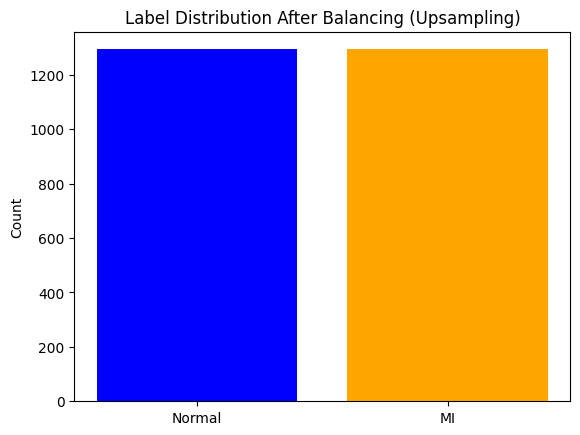

In [56]:
from sklearn.utils import resample
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Check original distribution
print("Original Label Distribution:", Counter(y))

# Separate majority and minority classes
X_majority = X_additional[y == 0]
X_minority = X_additional[y == 1]

# If minority class is class 0, flip the variables
if len(X_majority) < len(X_minority):
    X_majority, X_minority = X_minority, X_majority
    y_majority = [1] * len(X_majority)
    y_minority = [0] * len(X_minority)
else:
    y_majority = [0] * len(X_majority)
    y_minority = [1] * len(X_minority)

# Upsample the minority class
X_minority_upsampled = resample(X_minority,
                                replace=True,
                                n_samples=len(X_majority),
                                random_state=42)

# Combine majority and upsampled minority
X_balanced = np.vstack((X_majority, X_minority_upsampled))
y_balanced = np.array(y_majority + [y_minority[0]] * len(X_minority_upsampled))

# Check new distribution
from collections import Counter
print("✅ Balanced Label Distribution:", Counter(y_balanced))

# Plot the balanced class distribution
plt.bar(['Normal', 'MI'], [Counter(y_balanced)[0], Counter(y_balanced)[1]], color=['blue', 'orange'])
plt.title("Label Distribution After Balancing (Upsampling)")
plt.ylabel("Count")
plt.show()

In [57]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the balanced features
X_scaled = scaler.fit_transform(X_balanced)

# Show a few samples
print("✅ Scaled Feature Matrix Shape:", X_scaled.shape)
print("✅ First Row (Scaled):", X_scaled[0])
print("✅ Mean (approx):", np.round(X_scaled.mean(axis=0)[:5], 2))
print("✅ Std Dev (approx):", np.round(X_scaled.std(axis=0)[:5], 2))

✅ Scaled Feature Matrix Shape: (2588, 17)
✅ First Row (Scaled): [ 0.89801136  0.73939115 -1.63897439  1.21767689  0.74134686  0.89801136
  1.05990806  0.87213921  0.98395622  0.9781672   1.04638394 -1.08493665
 -1.06836589 -1.09211045 -1.03107643 -1.06250394 -1.05083687]
✅ Mean (approx): [-0.  0. -0. -0.  0.]
✅ Std Dev (approx): [1. 1. 1. 1. 1.]


In [58]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# 5.1 Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5.2 Define classifiers and their hyperparameter grids
models = {
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [100, 200],
        'max_depth': [None, 10]
    }),
    'SVM': (SVC(probability=True), {
        'C': [0.1, 1],
        'kernel': ['rbf', 'linear']
    }),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
        'n_estimators': [100],
        'max_depth': [3, 5]
    }),
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'C': [0.1, 1, 10]
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7]
    })
}

# 5.3 Train models using GridSearchCV
results = {}
for name, (model, param_grid) in models.items():
    grid = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X_scaled, y_balanced)  # Use scaled, balanced data from Step 4
    results[name] = {
        'Best Score': grid.best_score_,
        'Best Estimator': grid.best_estimator_,
        'Best Params': grid.best_params_
    }

# Print results
for model_name, details in results.items():
    print(f"🔹 {model_name}")
    print(f"   ✅ Best Accuracy: {details['Best Score']:.4f}")
    print(f"   📌 Best Parameters: {details['Best Params']}")
    print()

C:\Users\Srishti\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [18:10:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 RandomForest
   ✅ Best Accuracy: 0.9702
   📌 Best Parameters: {'max_depth': None, 'n_estimators': 100}

🔹 SVM
   ✅ Best Accuracy: 0.9625
   📌 Best Parameters: {'C': 0.1, 'kernel': 'rbf'}

🔹 XGBoost
   ✅ Best Accuracy: 0.9706
   📌 Best Parameters: {'max_depth': 5, 'n_estimators': 100}

🔹 LogisticRegression
   ✅ Best Accuracy: 0.9625
   📌 Best Parameters: {'C': 0.1}

🔹 KNN
   ✅ Best Accuracy: 0.9617
   📌 Best Parameters: {'n_neighbors': 5}



In [59]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Use the best models from Step 5
best_rf = results['RandomForest']['Best Estimator']
best_svm = results['SVM']['Best Estimator']
best_xgb = results['XGBoost']['Best Estimator']

# ------------------------------------------
# 6.1 Hard Voting Classifier (majority vote)
# ------------------------------------------
voting_clf_hard = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('svm', best_svm),
        ('xgb', best_xgb)
    ],
    voting='hard'
)

# Evaluate hard voting
hard_scores = cross_val_score(voting_clf_hard, X_scaled, y_balanced, cv=5, scoring='accuracy')
print("✅ Hard Voting Accuracy (mean of 5-fold CV):", round(hard_scores.mean(), 4))


# ------------------------------------------
# 6.2 Soft Voting Classifier (average probabilities)
# ------------------------------------------
voting_clf_soft = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('svm', best_svm),
        ('xgb', best_xgb)
    ],
    voting='soft'
)

# Evaluate soft voting
soft_scores = cross_val_score(voting_clf_soft, X_scaled, y_balanced, cv=5, scoring='accuracy')
print("✅ Soft Voting Accuracy (mean of 5-fold CV):", round(soft_scores.mean(), 4))


# ------------------------------------------
# 6.3 Stacking Classifier
# ------------------------------------------
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('svm', best_svm)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

# Evaluate stacking
stack_scores = cross_val_score(stacking_clf, X_scaled, y_balanced, cv=5, scoring='accuracy')
print("✅ Stacking Accuracy (mean of 5-fold CV):", round(stack_scores.mean(), 4))

C:\Users\Srishti\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [18:10:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Srishti\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [18:10:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Srishti\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [18:10:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Srishti\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [18:10:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\

✅ Hard Voting Accuracy (mean of 5-fold CV): 0.9718


C:\Users\Srishti\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [18:10:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Srishti\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [18:10:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Srishti\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [18:10:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Srishti\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [18:10:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\

✅ Soft Voting Accuracy (mean of 5-fold CV): 0.9706
✅ Stacking Accuracy (mean of 5-fold CV): 0.9668


C:\Users\Srishti\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [18:12:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 0.9614
✅ Precision: 0.9838
✅ Recall: 0.9382
✅ F1 Score: 0.9605
✅ ROC-AUC Score: 0.9753


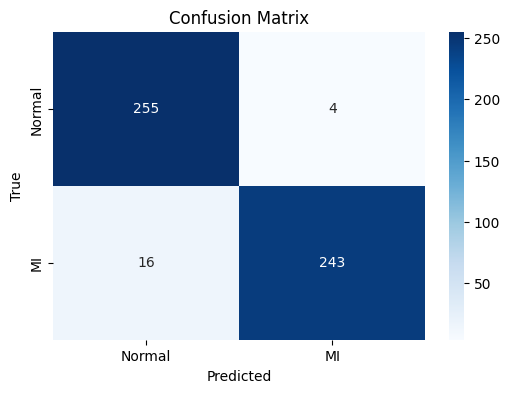

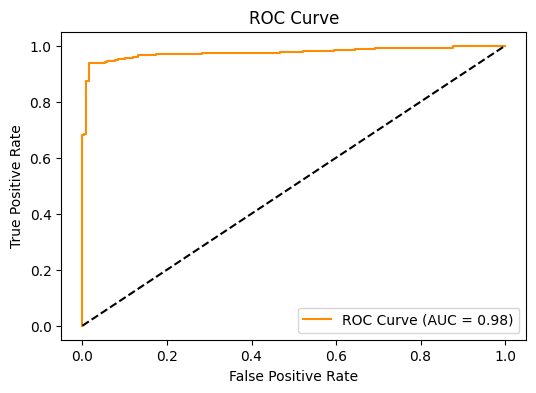

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Choose Best Ensemble Model ----
best_ensemble = voting_clf_soft  # or stacking_clf, based on Step 6 results

# ---- Train/Test Split ----
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# ---- Fit & Predict ----
best_ensemble.fit(X_train, y_train)
y_pred = best_ensemble.predict(X_test)
y_proba = best_ensemble.predict_proba(X_test)[:, 1]

# ---- Evaluation Metrics ----
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("✅ Accuracy:", round(acc, 4))
print("✅ Precision:", round(prec, 4))
print("✅ Recall:", round(rec, 4))
print("✅ F1 Score:", round(f1, 4))
print("✅ ROC-AUC Score:", round(roc_auc, 4))

# ---- Confusion Matrix ----
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'MI'], yticklabels=['Normal', 'MI'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

# ---- ROC Curve ----
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.show()

 98%|===================| 1019/1036 [00:38<00:00]       

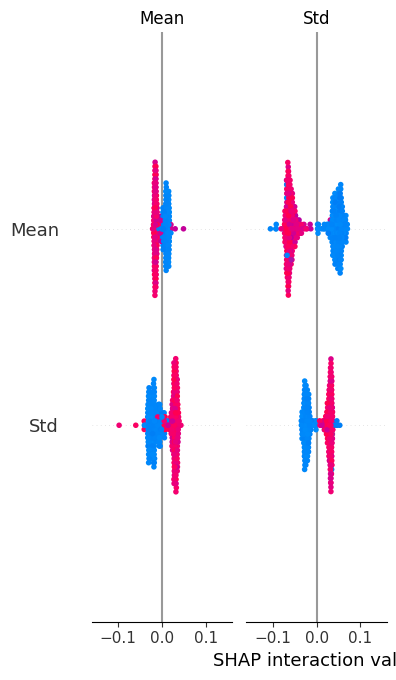

In [64]:
import shap

# Use XGBoost or Random Forest for SHAP explanations
model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Initialize SHAP explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot (shows overall feature importance)
shap.summary_plot(shap_values, X_test, feature_names=[
    'Mean', 'Std', 'Skew', 'Kurtosis', 'RMS',
    'FFT1','FFT2','FFT3','FFT4','FFT5','FFT6','FFT7','FFT8','FFT9','FFT10',
    'PSD_Mean', 'PSD_Max'
])

In [66]:
import numpy as np
from sklearn.metrics import accuracy_score

# Add Gaussian noise to test features
X_test_noisy = X_test + np.random.normal(0, 0.05, X_test.shape)

# Predict on noisy data
y_pred_noisy = best_ensemble.predict(X_test_noisy)

# Compare performance
acc_clean = accuracy_score(y_test, y_pred)
acc_noisy = accuracy_score(y_test, y_pred_noisy)

print("✅ Accuracy on original test set:", round(acc_clean, 4))
print("🧪 Accuracy on noisy test set:", round(acc_noisy, 4))
print("📉 Accuracy drop due to noise:", round(acc_clean - acc_noisy, 4))

✅ Accuracy on original test set: 0.9614
🧪 Accuracy on noisy test set: 0.9402
📉 Accuracy drop due to noise: 0.0212
